In [2]:
# Nosso modelo é feito com o torch
# Usaremos algumas classes de insetos (cada classe é uma subpasta de "model_classes", contendo fotos do inseto)
# Só precisamos treinar o modelo para entender e classificar cada inseto quanto tiver uma foto dele

import torch, os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
# Primeiro preparamos os dados
data_dir = 'model_classes' #Pasta model_classes, no caso, está na pasta que contém a subpasta do notebook
num_classes = 5 # Número de classes. Poderiamos usar OS + len aqui, mas por hora, faremos com um número menor e fixo.

batch_size = 16 # Número de imagens que serão processadas por vez (quanto maior, mais memória é usada)
num_epochs = 10 # Número de vezes que o modelo vai ver todas as imagens de treino, quanto maior esse número, geralmente é melhor, mas pode gerar overfitting

# Transformações que serão aplicadas nas imagens
transform = transforms.Compose([
    transforms.ToTensor(), # Primeiro convertemos a imagem para um tensor (um array multidimensional)
    transforms.Normalize(mean=[0.5], std=[0.5]), # Depois normalizamos os valores dos pixels para que fiquem entre -1 e 1
    transforms.Resize((224, 224), antialias=True) # Por fim, redimensionamos a imagem para 224x224 (tamanho padrão para o modelo)
])

# Carregamos as imagens de treino e teste
train_dataset = torchvision.datasets.ImageFolder(root=data_dir+'/train', transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root=data_dir+'/test', transform=transform)

# Criamos um iterador para as imagens de treino e teste
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

# Agora criamos o modelo
# Usaremos a arquitetura ResNet-18, que é um modelo pré-treinado
# Isso significa que ele já foi treinado com milhões de imagens para reconhecer objetos
# E nós vamos usar esse modelo para reconhecer insetos
# Por isso, precisamos congelar os parâmetros do modelo, para que ele não seja treinado novamente
# E vamos adicionar uma camada linear no final, para que ele reconheça insetos
model = torchvision.models.resnet18(weights="IMAGENET1K_V1")
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(512, num_classes)

# Agora criamos a função de perda (loss) e o otimizador
# Usaremos a função de perda Cross Entropy Loss
# E o otimizador Adam (é um dos melhores pra esse caso, mas precisa de uma boa base de dados)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())


# Primeiro definimos o dispositivo que será usado (GPU ou CPU), eu usarei uma GPU pois é disponível em meu computador
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Salvaremos o modelo na raiz do arquivo do notebook
model_path = 'model_5.pth'

# Agora treinamos o modelo
model.to(device)
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

# Salvamos o modelo
torch.save(model.state_dict(), model_path)

Epoch [1/10], Loss: 1.1634
Epoch [2/10], Loss: 0.4931
Epoch [3/10], Loss: 0.9504
Epoch [4/10], Loss: 0.1272
Epoch [5/10], Loss: 0.4511
Epoch [6/10], Loss: 0.7025
Epoch [7/10], Loss: 0.1815
Epoch [8/10], Loss: 0.5882
Epoch [9/10], Loss: 0.8040
Epoch [10/10], Loss: 0.2401


              precision    recall  f1-score   support

   Borboleta       0.93      0.89      0.91       132
   Gafanhoto       0.80      0.87      0.83       117
    Joaninha       0.95      0.92      0.93       121
    Libélula       0.86      0.83      0.85       109
    Mosquito       0.94      0.95      0.94        81

    accuracy                           0.89       560
   macro avg       0.89      0.89      0.89       560
weighted avg       0.89      0.89      0.89       560



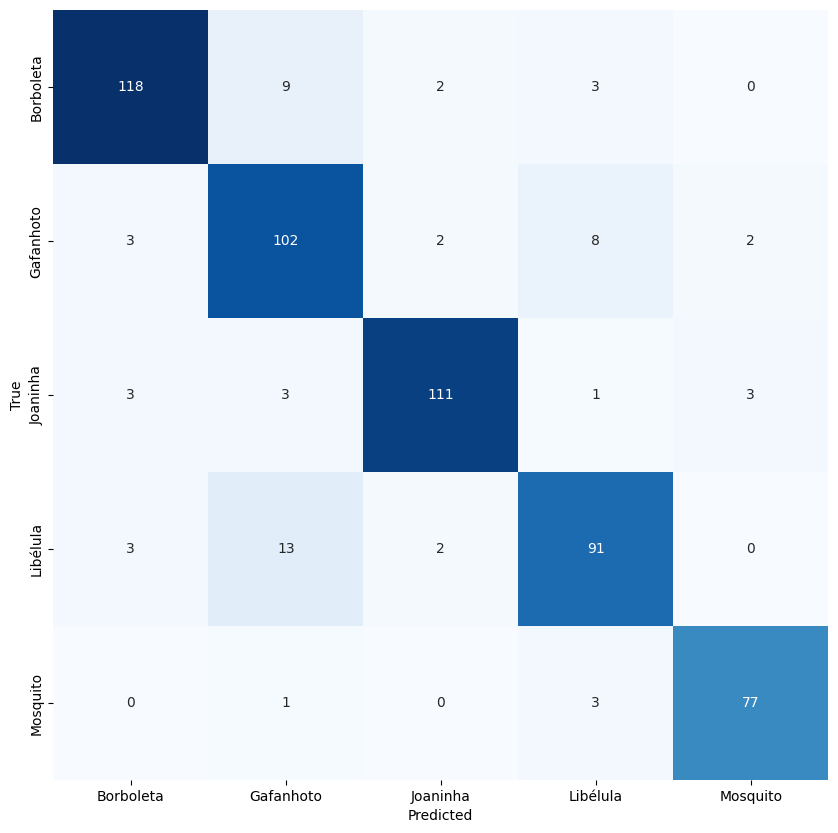

In [5]:
# Verificamos a precisão, recall, f1-score, curvas de perdas e matriz de confusão.
model.eval()

y_pred = []
y_true = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.tolist())
        y_true.extend(labels.tolist())
        total += labels.size(0)
        correct += (predicted==labels).sum().item()

print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
# Ajustamos para exibir o nome das classes invés dos números
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

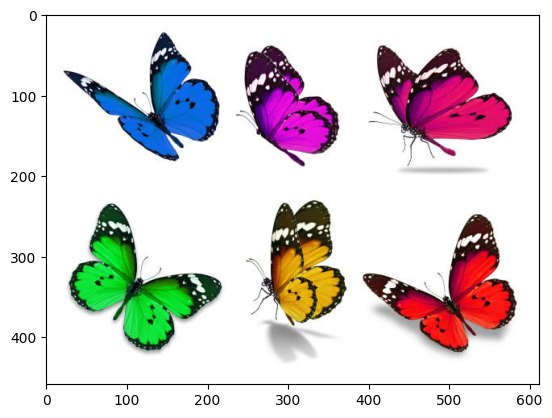

Borboleta


In [21]:
# Agora usamos o modelo para classificar uma imagem
# Primeiro definimos as classes
classes = ['Borboleta', 'Gafanhoto', 'Joaninha', 'Libélula', 'Mosquito']

# Agora carregamos uma imagem
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

img = Image.open('model_classes/test/Borboleta/istockphoto283.jpg') # Carregamos a imagem
plt.imshow(img)
plt.show()

# Agora preparamos a imagem para ser classificada
img = transform(img)
img = img.to(device)
img = img.unsqueeze(0)


# Por fim, classificamos a imagem
with torch.no_grad():
    output = model(img)
    _, predicted = torch.max(output.data, 1)
    print(classes[predicted.item()])


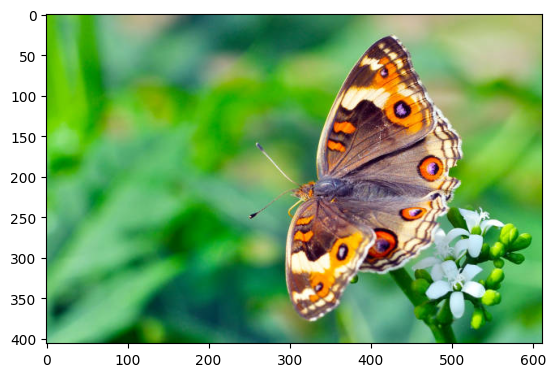

Borboleta


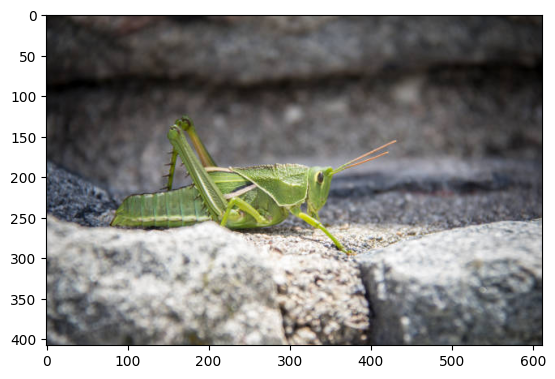

Gafanhoto


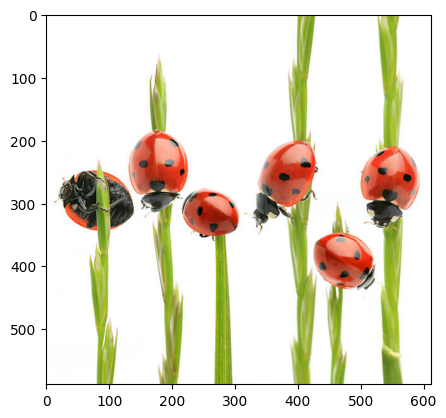

Joaninha


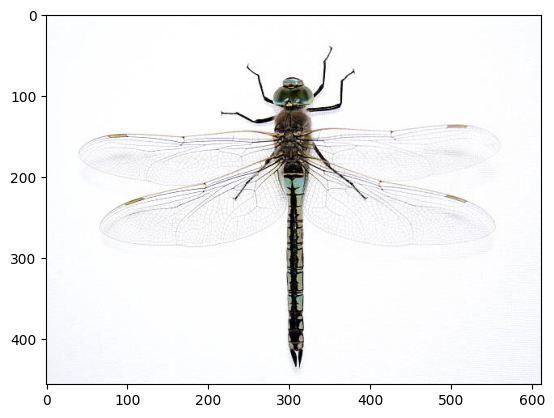

Libélula


In [22]:
# Vamos definir uma função para fazer mais testes de classificação
def predict_image(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.show()
    img = transform(img)
    img = img.to(device)
    img = img.unsqueeze(0)
    with torch.no_grad():
        output = model(img)
        _, predicted = torch.max(output.data, 1)
        print(classes[predicted.item()])

# Agora vamos testar com mais imagens
predict_image('model_classes/test/Borboleta/istockphoto313.jpg')
predict_image('model_classes/test/Gafanhoto/istockphoto355.jpg')
predict_image('model_classes/test/Joaninha/istockphoto23.jpg')
predict_image('model_classes/test/Libélula/istockphoto370.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

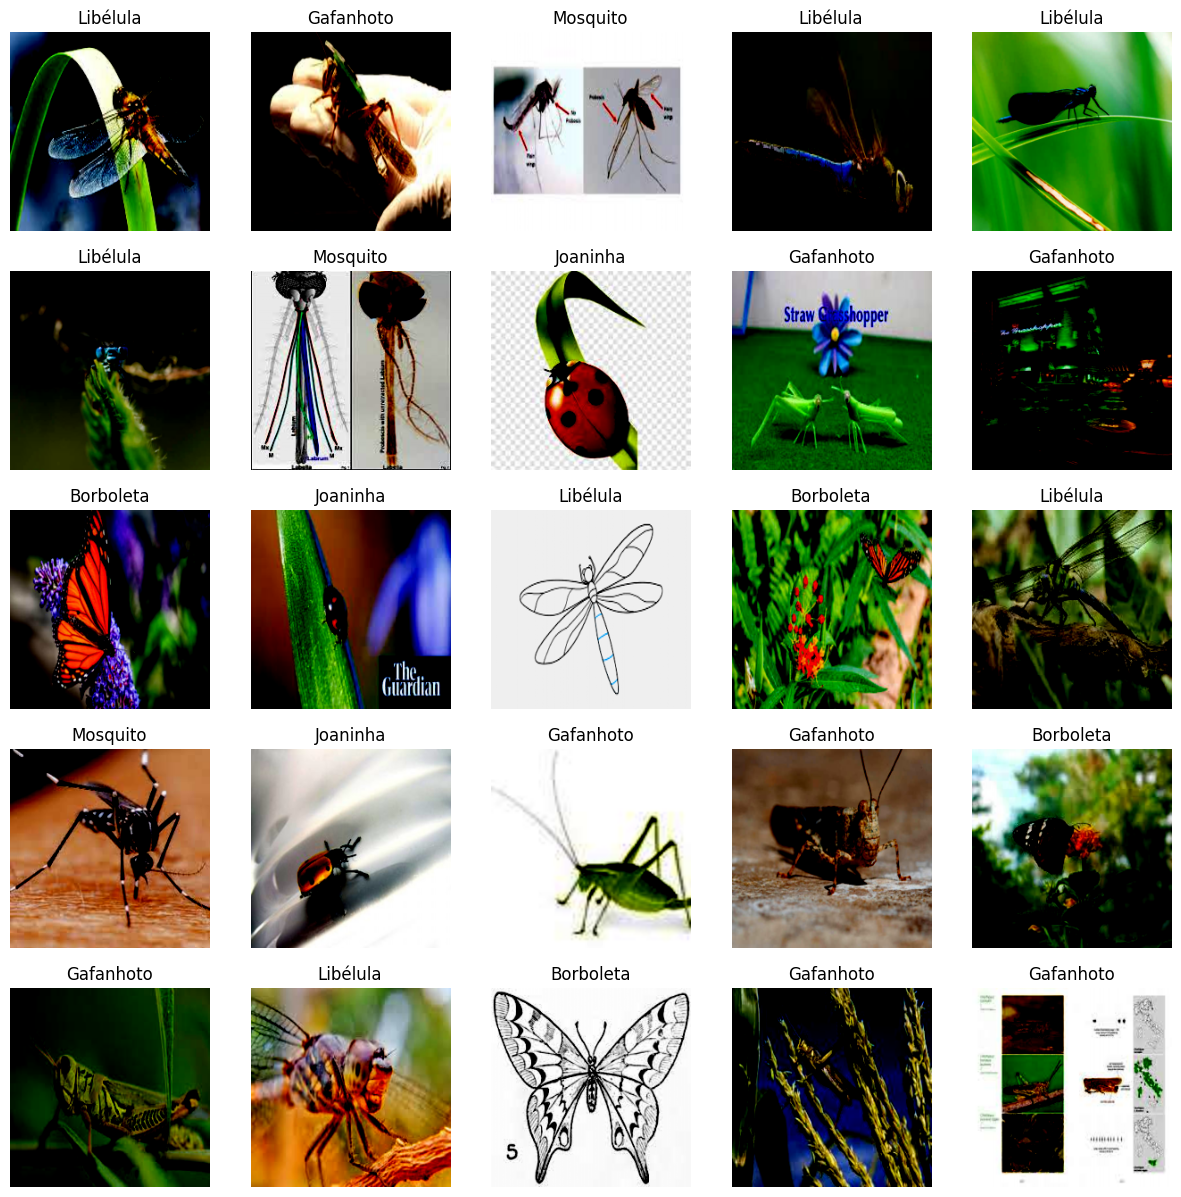

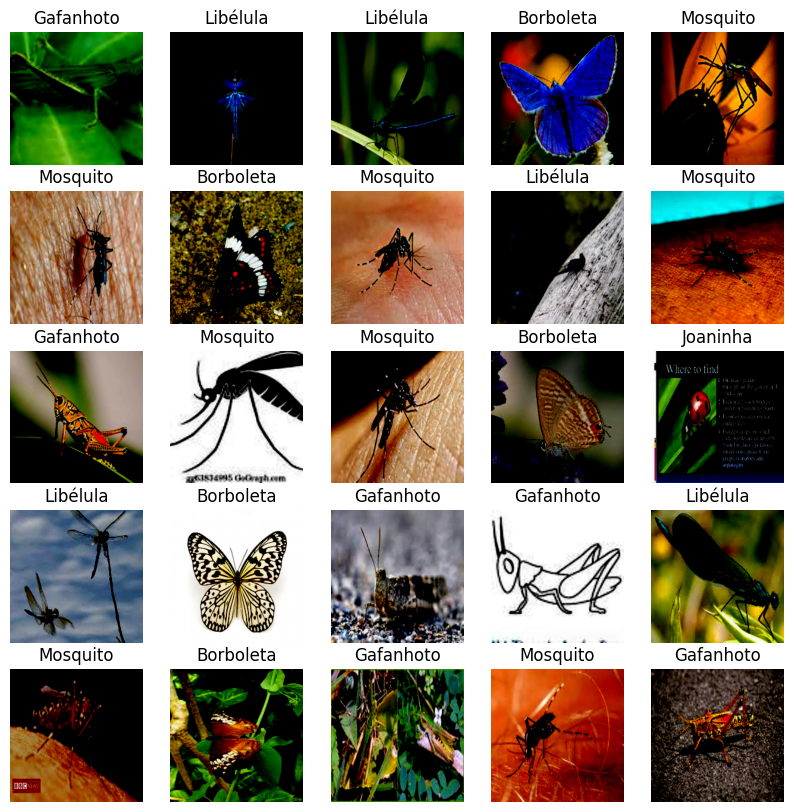

In [12]:
# Análise exploratória


plt.figure(figsize=(15, 15)) # tamanho da figura

# Primeiro exibimos 5 imagens de cada classe
for i in range(len(classes)):
    for j in range(5):
        image, label = next(iter(train_loader))
        image = image.squeeze(0)
        image = image.numpy()
        image = np.transpose(image, (1, 2, 0))
        plt.subplot(5, 5, i * 5 + j + 1)
        plt.imshow(image, vmin=0, vmax=1)
        plt.title(classes[label.item()])
        plt.axis('off')

# Agora exibimos 25 imagens aleatórias
plt.figure(figsize=(10, 10))  #tamanho para a segunda figura
for i in range(25):
    image, label = next(iter(train_loader))
    image = image.squeeze(0)
    image = image.numpy()
    image = np.transpose(image, (1, 2, 0))
    plt.subplot(5, 5, i + 1)
    
    plt.imshow(image, vmin=0, vmax=1)  # Os valores 0 e 1 são adequados para imagens normalizadas
    plt.title(classes[label.item()])
    plt.axis('off')

plt.show()